In [ ]:
!pip install wget
!pip install ktrain
!pip install jsonlines
!pip install transformers


# """
# TODO: 
# Implement VBPR
# implement vista
# implement new
# """

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9673 sha256=31bad716e9835d441827bd30e3f64223f8bcac9edba2ebe01aae79f29bfc2f78
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
     |████████████████████████████████| 25.3 MB 1.4 MB/s 
     |████████████████████████████████| 6.8 MB 71.3 MB/s 
     |████████████████████████████████| 981 kB 79.0 MB/s 
     |████████████████████████████████| 263 kB 69.2 MB/s 
     |████████████████████████████████| 1.9 MB 67.9 MB/s 
     |████████████████████████████████| 1.2 MB 67.2 MB/s 
     |████████████████████████████████| 468 kB 58.6 MB/s 
     |████████████████████████████████| 3.3 MB 49.2 MB/s 
     |████████████████████████████████| 895 kB 57.5 MB/s 
  Created wheel for ktrain: filename=ktrain-0.27.2-py3-none-any.whl size=25283087 sha256=bba823b55e986077e0887875b25de5825e1b6c4acd22fe81af001c743355e6ca
  Stored in directory: /root/.cache/pip/wheels/88/

In [ ]:
from google.colab import auth
auth.authenticate_user()

!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

!mkdir ~/reddit
!gcsfuse pushshift_reddit ~/reddit

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0   112k      0 --:--:-- --:--:-- --:--:--  112k
OK
94 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 94 not upgraded.
Need to get 10.8 MB of archives.
After this operation, 23.1 MB of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 160837 files and directories currently installed.)
Preparing to unpack .../gcsfuse_0.35.1_amd64.deb ...
Unpacking gcsfuse (0.35.1) ...
Setting up gcsfuse (0.35.1) ...
2021/08/03 12:04:37.372746 Using mount point: /root/reddit
2021/08/03 12:04:37.379715 Opening GCS connection...
2021/08/03 12:04:38.188166 Mounting file system "pushshift_reddit"...
2021/08/03 12:04:38.218851 File system has been 

In [ ]:
import jsonlines
import pickle 
import numpy
import ktrain
from ktrain import text

from tqdm.auto import tqdm
from itertools import islice


def pickle_save(obj, path):
    with open(path, "wb") as f:
        pickle.dump(obj, f)


def pickle_load(path):
    with open(path, "rb") as f:
        obj = pickle.load(f)
    return obj


def chunks(iterable, size=10):
    iterator = iter(iterable)
    for first in iterator:    # stops when iterator is depleted
        def chunk():          # construct generator for next chunk
            yield first       # yield element from for loop
            for more in islice(iterator, size - 1):
                yield more    # yield more elements from the iterator
        yield chunk()         # in outer generator, yield next chunk

In [ ]:
import os
import sys
import logging
import random
import subprocess
import jsonlines 
import ktrain 
import wget
import gc 
import json 
import hashlib
import sklearn

import scipy.stats as st
import numpy as np

from itertools import groupby
from sklearn.metrics import ndcg_score
from tqdm.auto import tqdm
from collections import Counter, defaultdict
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from google.colab.patches import cv2_imshow
    

FEATURES = [ "user", "item", "author", "title", "year", "week", "day", "image_emotion"]


submission_keys = [
  "author",
  "title",
  "id",
  "created_utc"
]


comment_keys = [
  "author",
  "body",
  "link_id",
  "created_utc",
  "score"
]

emotions = {
  "ktrain":[
    "joy", "sadness", "anger", 
    "fear", "trust", "disgust", 
    "surprise", "neutral", "other"
  ],
  "bert":[ "sadness", "joy", "love", "anger", "fear", "surprise" ],
  "sent": ["1", "2", "3", "4", "5"]
}

logging.basicConfig(
    format='%(asctime)s [%(levelname)s] %(name)s - %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
    stream=sys.stdout,
)


class RedditDataset():

  def __init__(self, comments_file="comment.json", submissions_file="submission.json",
               min_user_interactions=5, max_user_interactions=1000, emotion_model="ktrain",
               keep_only_image_exists=False, progress=False, workdir="/root/reddit"):
    
    self.logger = logging.getLogger("RedditDataset")
    self.logger.info("Initializing dataset")
    
    self.comments_file = comments_file
    self.submissions_file = submissions_file
    self.min_user_interactions = min_user_interactions
    self.max_user_interactions = max_user_interactions
    self.keep_only_image_exists = keep_only_image_exists
    self.emotion_model = emotion_model
    self.progress = progress
    self.workdir = workdir

    self.item_image_id_map = pickle_load(f"{self.workdir}/subs_id_map")
    self.image_emotions = pickle_load(f"{self.workdir}/image_emotions_from_artemis.pkl")

    self.used_negatives = set()

  def build(self):
    self.logger.info("Building dataset.")

    self.logger.info("Indexing submissions.")
    self.indexed_items = { 
      item: (author, title, ts) 
      for author, title, item, ts in self.submissions_gen()
      if (item in self.item_image_id_map or not self.keep_only_image_exists) 
    }

    self.logger.info("Loading interactions.")
    self.interactions = list(self.comments_gen())

    self.logger.info("Building user histories.")
    self.user_histories = defaultdict(set)
    for user, comment, item, ts, score in tqdm(self.interactions, disable=not self.progress):
      if item in self.indexed_items:
        self.user_histories[user].add(item)

    self.logger.info("Building user set.")
    self.user_set = set([
      user for user, comments in self.user_histories.items() 
      if len(comments) > self.min_user_interactions 
      if len(comments) < self.max_user_interactions
    ])

    self.logger.info("Building filtered interaction set.")
    self.user_item_pairs = list(set([
      (user, item) for user, comment, item, ts, score in tqdm(self.interactions, disable=not self.progress)
      if item in self.indexed_items
      if user in self.user_set
    ]))

    self.item_set = set([item for user, item in self.user_item_pairs])
    self.item_list = list(self.item_set)

    self.logger.info("Cleaning indexed items.")
    self.indexed_items = {
      item: data for item, data in self.indexed_items.items() 
      if item in self.item_set
    }

    self.logger.info("Indexing comments.")
    self.indexed_interactions = { 
        (user, item): (comment, ts, score) 
        for user, comment, item, ts, score in tqdm(self.interactions, disable=not self.progress) 
        if item in self.item_set
        if user in self.user_set
    }

    self.logger.info("Building sets of authors and titles")
    self.author_set = set([author for author, title, ts in self.indexed_items.values()])
    self.title_set = set([title for author, title, ts in self.indexed_items.values()])

    self.logger.info("Extracting comment emotions.")
    
    if self.emotion_model == "ktrain":
      self.ktrain_emotions()
    elif self.emotion_model == "bert":
      self.bert_emotions()
    else:
      self.bert_sentiment()
    
    self.logger.info("Done!")

  def preprocess_images(self):
    import tensorflow as tf
    from tensorflow.keras.applications.vgg16 import VGG16
    from tensorflow.keras.preprocessing import image
    from tensorflow.keras.applications.vgg16 import preprocess_input
    import numpy as np

    model = VGG16(weights='imagenet', include_top=True)
    model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-2].output)

    def extract_batch_feats(batch):
        x = np.asarray(list(batch))
        x = tf.keras.layers.experimental.preprocessing.Resizing(224, 224, interpolation='bilinear')(x)
        x = preprocess_input(x)
        result = model.predict(x) 
        yield result[0]

    self.image_features = [
      x 
      for image_batch in tqdm(chunks(self.numpy_images, size=512), total=len(dataset.numpy_images) / 512)
      for x in extract_batch_feats(image_batch)
    ]

  def ktrain_emotions(self):
    b_size = 256
    predictor = ktrain.load_predictor(f"{self.workdir}/ktrain_best_emotion_model")
    comments = [self.indexed_interactions[(user, item)][0] for user, item in tqdm(self.user_item_pairs, disable=not self.progress)]
    chunked_data = tqdm(
      chunks(comments, b_size),
      total=len(comments) / b_size, 
      ncols=130, 
      miniters=int(50), 
      maxinterval = 1000, 
      disable=not self.progress
    ) 
    self.comment_emotions = [
      cv 
      for b in chunked_data
      for cv in predictor.predict_proba(list(b))
    ]
    self.indexed_comment_emotions = { 
        (user, item): v 
        for  (user, item), v in zip(self.user_item_pairs, self.comment_emotions) 
    }
  
  def bert_emotions(self):
    from transformers import AutoTokenizer, AutoModelForSequenceClassification
  
    tokenizer = AutoTokenizer.from_pretrained("nateraw/bert-base-uncased-emotion")
    model = AutoModelForSequenceClassification.from_pretrained("nateraw/bert-base-uncased-emotion").to('cuda:0')


    def handle_batch(batch):
      inputs = tokenizer(batch, padding=True, truncation=True, max_length=512, return_tensors="pt").to('cuda:0')
      outputs = model(**inputs)
      outputs = outputs["logits"].tolist()
      outputs = [np.exp(o) / np.sum(np.exp(o)) for o in outputs]
      return outputs

    b_size = 8
    comments = [dataset.indexed_interactions[(user, item)][0] for user, item in tqdm(dataset.user_item_pairs, disable=False)]
    chunked_data = tqdm(
      chunks(comments, b_size),
      total=len(comments) / b_size, 
      ncols=130, 
      miniters=int(50), 
      maxinterval = 1000, 
      disable=False
    ) 

    comment_emotions = [
      cv 
      for b in chunked_data
      for cv in handle_batch(list(b))
    ]

    self.indexed_comment_emotions = { 
        (user, item): v 
        for  (user, item), v in zip(self.user_item_pairs, comment_emotions) 
    }

  def bert_sentiment(self):
    from transformers import AutoTokenizer, AutoModelForSequenceClassification

    tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
    model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment").to('cuda:0')

    def handle_batch(batch):
      inputs = tokenizer(batch, padding=True, truncation=True, max_length=512, return_tensors="pt").to('cuda:0')
      outputs = model(**inputs)
      outputs = outputs["logits"].tolist()
      outputs = [np.exp(o) / np.sum(np.exp(o)) for o in outputs]
      return outputs

    b_size = 8
    comments = [dataset.indexed_interactions[(user, item)][0] for user, item in tqdm(dataset.user_item_pairs, disable=False)]
    chunked_data = tqdm(
      chunks(comments, b_size),
      total=len(comments) / b_size, 
      ncols=130, 
      miniters=int(50), 
      maxinterval = 1000, 
      disable=False
    ) 

    comment_emotions = [
      cv 
      for b in chunked_data
      for cv in handle_batch(list(b))
    ]

    self.indexed_comment_emotions = { 
        (user, item): v 
        for  (user, item), v in zip(self.user_item_pairs, comment_emotions) 
    }

  def save(self):
    
    location = self.get_path()

    pickle_save((
      self.indexed_items, 
      self.indexed_interactions,
      self.indexed_comment_emotions,
      self.user_item_pairs
    ), f"{self.workdir}/{location}")

  def load(self):

    location = self.get_path()

    (self.indexed_items, 
    self.indexed_interactions,
    self.indexed_comment_emotions,
    self.user_item_pairs) = pickle_load(f"{self.workdir}/{location}")

    self.user_set = set([user for user, item in self.user_item_pairs])
    self.item_set = set([item for user, item in self.user_item_pairs])
    self.author_set = set([author for author, title, ts in self.indexed_items.values()])
    self.title_set = set([title for author, title, ts in self.indexed_items.values()])
    self.item_list = list(self.item_set)
    self.item_image_id_map = pickle_load(f"{self.workdir}/subs_id_map")
    self.image_emotions = pickle_load(f"{self.workdir}/image_emotions_from_artemis.pkl")
    self.image_features = pickle_load(f"{self.workdir}/image_features_vgg16.pkl")

  def comments_gen(self, total=4261608):
    with jsonlines.open(f"{self.workdir}/{self.comments_file}") as reader:
      for obj in tqdm(reader, total=total, desc="comments", disable=not self.progress):
        if obj['parent_id'] == obj['link_id']:
          obj['link_id'] = obj['link_id'].replace("t3_", "")
          yield [obj.get(k) for k in comment_keys]

  def submissions_gen(self, total=1466539):
    with jsonlines.open(f"{self.workdir}/{self.submissions_file}") as reader:
      for obj in tqdm(reader, total=1466539, desc="submissions", disable=not self.progress):
        yield [obj.get(k) for k in submission_keys]

  def create_negatives(self, pairs, n):
    for user, item in pairs:
      counter = 0 
      tries = 0
      while counter < n and tries < 2 * n:
        
        negative = random.choice(self.item_list)
        negative_pair = (user, negative)
        tries += 1

        if negative_pair not in self.used_negatives:
          self.used_negatives.add((user, negative))
          yield user, negative
          counter += 1

  def build_training_datasets(self, test_size=0.1):
    self.train, self.test = train_test_split(self.user_item_pairs, test_size=0.1, shuffle=True)

  def download_images(self):
    if not os.path.exists("images75388.mymemmap"):
      self.logger.info("Downloading images...")
      url = "https://storage.googleapis.com/pushshift_reddit/images75388.mymemmap"
      filename = wget.download(url)
    
    self.numpy_images = numpy.memmap("images75388.mymemmap", dtype='uint8', mode='r', shape=(75388, 256, 256, 3))

  
  def get_image(self, item):
    id = self.item_image_id_map.get(item, None)
    
    if id is not None:
      return self.image_features[id]
    else:
      return np.zeros(4096)

  def info(self):
    counts_message = f"Users: {len(self.user_set)}, Items: {len(self.item_set)}, Interactions: {len(self.user_item_pairs)}"
    print(counts_message)

    label_counts = Counter(np.argmax(emotion) for emotion in self.indexed_comment_emotions.values())
    total = len(self.user_item_pairs)
    
    label_pc = sorted([(k, v/total) for k, v in label_counts.items() ], key=lambda x: x[0])
    # print(label_pc)
    label_pc_message = ", ".join([f"{emotions[self.emotion_model][e]}: {pc:.2f}" for e, pc in label_pc])
    print(label_pc_message)

  def calculate_class_weights(self):
    y_integers = np.argmax(np.asarray([em for em in self.indexed_comment_emotions.values()]), axis=1)
    class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
    self.class_weights = dict(enumerate(class_weights))

  def append_features(self, sample, rec_weights, use_em_weights=True, em_soft=False):
    user, item, label = sample
    author, title, ts = self.indexed_items[item]
    dt = datetime.fromtimestamp(ts)
    year, week, day = dt.isocalendar()

    image_id = self.item_image_id_map.get(item, None)

    if image_id is not None:
      image_emotion = self.image_emotions[image_id]
    else:
      image_emotion = np.zeros(9)

    w_rec = rec_weights[0]
    w_em = 0.0

    emotion_dims = len(emotions[dataset.emotion_model])
    emotion_vec = np.zeros(emotion_dims)

    if label:
      emotion_vec = self.indexed_comment_emotions[(user, item)]
      emotion = np.argmax(emotion_vec)
      
      if use_em_weights:
        w_em = self.class_weights[emotion]
      else:
        w_em = 1.0

      if em_soft:
        w_em *= np.max(emotion_vec)
      
      w_rec = rec_weights[1]

    return (user, item, author, title, year - 2008, week, day, image_emotion.squeeze()), label, emotion_vec, w_rec, w_em

  def batch_gen(self, source="train", epochs=10, batch_size=1024, n=10, method="normal", use_image=False, rec_weights=(0.1, 1.0), use_em_weights=True, em_soft=False):
    
    if source == "train":
      dataset = self.train
    else:
      dataset = self.test

    for epoch in range(epochs):
      if n:
        negative_pairs = list(self.create_negatives(dataset, n))
      else:
        negative_pairs = []
      
      data = [(u, i, 1) for u, i in dataset] + [(u, i, 0) for u, i in negative_pairs]
      random.shuffle(data)
      
      for b in chunks(data, batch_size):
        b = list(b)
        train_array = [self.append_features(sample, rec_weights, use_em_weights=use_em_weights, em_soft=use_em_weights) for sample in b]
        X, Y, E, W_REC, W_EM = list(zip(*train_array))
        Y = np.asarray(Y)
        E = np.asarray(E)
        W_REC = np.asarray(W_REC)
        W_EM = np.asarray(W_EM)
        X = { FEATURES[i]: np.asarray(x) for i, x in enumerate(list(zip(*X)))}
        
        if use_image:
          IM = np.asarray([self.get_image(item) for user, item, label in b])
          X["image"] = IM
        
        yield X, [Y, E], { "candidate_score": W_REC, "emotion": W_EM }

  def get_training_artifacts(self, epochs=10, batch_size=32, n=10, use_image=False, rec_weights=(0.1, 1.0), k=1000, use_em_weights=True, em_soft=False):
    
    self.used_negatives = set()

    train_gen = self.batch_gen(source="train", epochs=epochs, batch_size=batch_size, n=n, use_image=use_image, rec_weights=rec_weights, use_em_weights=use_em_weights, em_soft=em_soft)
    valid_gen = self.batch_gen(source="test", epochs=epochs, batch_size=batch_size, n=n, use_image=use_image, rec_weights=rec_weights, use_em_weights=use_em_weights, em_soft=False)
    train_steps = int(len(self.train) * (n + 1) / batch_size)
    valid_steps = int(len(self.test) * (n + 1) / batch_size)

    sorted_test = sorted(self.test, key=lambda x: x[0])
    grouped_test = [(k, list(set([i for k, i in g]))) for k, g in groupby(sorted_test, lambda x: x[0])]

    def test_batches_gen():
      for user, positives in tqdm(grouped_test, disable=True):
        negative_samples = random.choices(self.item_list, k=k)
        d = [(user, item, 1) for item in positives] + [(user, item, 0) for item in negative_samples]
        d = d[0:k]
        x = [self.append_features(sample, rec_weights)[0] for sample in d]
        x = { FEATURES[i]: np.asarray(x_i) for i, x_i in enumerate(list(zip(*x)))}

        if use_image:
          IM = np.asarray([self.get_image(item) for user, item, label in d])
          x["image"] = IM
        
        yield x

    return train_gen, train_steps, valid_gen, valid_steps, test_batches_gen, grouped_test

  def get_path(self):
    a = json.dumps(self.info_dict(), sort_keys = True).encode("utf-8")
    h = hashlib.md5(a).hexdigest()
    return f"dataset_{h}"

  def info_dict(self):
    return {
        "min_user_interactions": self.min_user_interactions,
        "max_user_interactions": self.max_user_interactions,
        "keep_only_image_exists": self.keep_only_image_exists,
        # "users": len(self.user_set),
        # "items": len(self.item_set),
        # "interactions": len(self.user_item_pairs),
        "emotion_model": self.emotion_model
    }

  def random_item_check(self):
    user, item = random.choice(self.user_item_pairs)
    print(f"https://www.reddit.com/r/Art/comments/{item}/")
    if item in self.item_image_id_map:
      image_id = self.item_image_id_map[item]
      img = self.numpy_images[image_id]
      img = np.flip(img, axis=-1)
      cv2_imshow(img)
      emotion = self.indexed_comment_emotions[(user, item)]
      comment, ts, score = self.indexed_interactions[(user, item)]
      print(f"User {user} commented: {comment}")
      emotion_string = ", ".join([f"{k}:{v:.2f}" for k, v in zip(emotions[self.emotion_model], emotion)])
      print(emotion_string)
    else:
      print("image not found")


  def bin_emotions(self, n_bins=4, encode="ordinal", strategy="kmeans"):
    keys_and_emotions = list(self.indexed_comment_emotions.items())
    emotions_vectors = np.asarray([v for k, v in keys_and_emotions])
    self.est = sklearn.preprocessing.KBinsDiscretizer(n_bins=n_bins, encode=encode, strategy=strategy)
    self.est.fit(emotions_vectors)
    emotions_binned = self.est.transform(emotions_vectors)
    self.indexed_comment_emotions_binned = {k: emotions_binned[i] for i, (k, v) in enumerate(keys_and_emotions)}


In [ ]:
dataset = RedditDataset(
    comments_file="comment_april.json", 
    submissions_file="submission_april.json", 
    progress=True, 
    keep_only_image_exists=False,
    min_user_interactions=10,
    max_user_interactions=1000,
    emotion_model="ktrain",
    workdir="/root/reddit"
)

2021-08-03 12:04:45 [INFO] RedditDataset - Initializing dataset


In [ ]:
# dataset.build()

In [ ]:
# dataset.save()

In [ ]:
dataset.load()

In [ ]:
dataset.build_training_datasets()
dataset.calculate_class_weights()
# dataset.bin_emotions(n_bins=2, strategy="quantile")

In [ ]:
dataset.info()

Users: 13738, Items: 162881, Interactions: 322579
joy: 0.46, sadness: 0.04, anger: 0.03, fear: 0.05, trust: 0.00, disgust: 0.01, surprise: 0.04, neutral: 0.38, other: 0.00


In [ ]:
dataset.info_dict()

{'emotion_model': 'ktrain',
 'keep_only_image_exists': False,
 'max_user_interactions': 1000,
 'min_user_interactions': 10}

In [ ]:
# dataset.random_item_check()

In [ ]:
dataset.image_features[0]

array([2.010148 , 2.106918 , 1.0427744, ..., 0.       , 0.       ,
       0.       ], dtype=float32)

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



def get_deep_model(dataset, dims=10, features=[], embeddings_regularizer=(1e-6, 1e-6), 
                   ff_regularizer=(1e-6, 1e-6), ff_drop=0.2, ff_init="he_uniform", ff_act="relu",
                   max_title_tokens=10000, layers=[512, 512], rec_w=1.0, 
                   em_w=1.0, embeddings_init="he_uniform"):

  emb_reg = tf.keras.regularizers.l1_l2(l1=embeddings_regularizer[0], l2=embeddings_regularizer[1])
  ff_reg = tf.keras.regularizers.l1_l2(l1=ff_regularizer[0], l2=ff_regularizer[1])

  inputs = []
  candidate_features = []
  scores = []

  if "image_emotion" in features:
    image_emotion_input = tf.keras.layers.Input((9,), name="image_emotion")
    x = tf.keras.layers.Reshape(target_shape=(1, 9), name="image_emotion_reshaped")(image_emotion_input)
    inputs.append(image_emotion_input)
    candidate_features.append(x)

  if "item" in features:
    print("creating item model")
    item_lookup_layer = tf.keras.layers.experimental.preprocessing.StringLookup(name="item_lookup")
    item_lookup_layer.adapt(list(dataset.item_set))

    item_embedding_table = tf.keras.layers.Embedding(
      item_lookup_layer.vocab_size(), dims, 
      name="item_embedding_table",
      embeddings_initializer=embeddings_init, 
      embeddings_regularizer=emb_reg,
      # embeddings_constraint=tf.keras.constraints.UnitNorm()
    )
    
    item = tf.keras.Input(1, name="item", dtype=tf.string)
    item_id = item_lookup_layer(item)
    item_embedding = item_embedding_table(item_id)
    
    inputs.append(item)
    candidate_features.append(item_embedding)

  if "author" in features:
    author_lookup_layer = tf.keras.layers.experimental.preprocessing.StringLookup(name="author_lookup")
    author_lookup_layer.adapt(list(dataset.author_set))

    author_embedding_table = tf.keras.layers.Embedding(
      author_lookup_layer.vocab_size(), dims, 
      name="author_embedding_table",
      embeddings_initializer=embeddings_init, 
      embeddings_regularizer=emb_reg,
      # embeddings_constraint=tf.keras.constraints.UnitNorm()
    )

    author = tf.keras.Input(1, name="author", dtype=tf.string)
    author_id = author_lookup_layer(author)
    author_embedding = author_embedding_table(author_id)

    inputs.append(author)
    candidate_features.append(author_embedding)

  if "title" in features:
    
    title_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(
        max_tokens=max_title_tokens, 
        output_mode='int', 
        output_sequence_length=10
    )
    title_vectorizer.adapt(list(dataset.title_set))
    
    title_embedding_table = tf.keras.layers.Embedding(
      max_title_tokens, dims, 
      name="title_embedding_table",
      embeddings_initializer=embeddings_init, 
      embeddings_regularizer=emb_reg,
      # embeddings_constraint=tf.keras.constraints.UnitNorm()
    )
    
    title_input = tf.keras.Input(shape=(1,), dtype=tf.string, name="title")
    title_token_ids = title_vectorizer(title_input)
    title_token_embeddings = title_embedding_table(title_token_ids)
    title_embedding = tf.keras.layers.GRU(dims)(title_token_embeddings)
    title_embedding = tf.keras.layers.Reshape(target_shape=(1, dims), name="title_reshaped")(title_embedding)
    candidate_features.append(title_embedding)
    inputs.append(title_input)


  if "time" in features:
    year_embedding_table = tf.keras.layers.Embedding(
      20, dims, 
      name="year_embedding_table",
      embeddings_initializer=embeddings_init, 
      embeddings_regularizer=emb_reg,
      embeddings_constraint=tf.keras.constraints.UnitNorm()
    )
    year_input = tf.keras.Input(shape=(1,), name="year")
    year_embedding = year_embedding_table(year_input)

    candidate_features.append(year_embedding)
    inputs.append(year_input)

    week_embedding_table = tf.keras.layers.Embedding(
      54, dims, 
      name="week_embedding_table",
      embeddings_initializer=embeddings_init, 
      embeddings_regularizer=emb_reg,
      # embeddings_constraint=tf.keras.constraints.UnitNorm()
    )
    week_input = tf.keras.Input(shape=(1,), name="week")
    week_embedding = week_embedding_table(week_input)
    
    candidate_features.append(week_embedding)
    inputs.append(week_input)
    
    day_embedding_table = tf.keras.layers.Embedding(
      8, dims, 
      name="day_embedding_table",
      embeddings_initializer=embeddings_init, 
      embeddings_regularizer=emb_reg,
      # embeddings_constraint=tf.keras.constraints.UnitNorm()
    )
    day_input = tf.keras.Input(shape=(1,), name="day")
    day_embedding = day_embedding_table(day_input)
    
    candidate_features.append(day_embedding)
    inputs.append(day_input)

  if "image" in features:
    image = tf.keras.Input(shape=(4096,), name="image")
    x = tf.keras.layers.Dense(dims, activation="relu")(image)
    x = tf.keras.layers.Reshape(target_shape=(1, dims))(x)
    inputs.append(image)
    candidate_features.append(x)


  if "user" in features:
    print("creating user model")
    
    user_lookup_layer = tf.keras.layers.experimental.preprocessing.StringLookup(name="user_lookup")
    user_lookup_layer.adapt(list(dataset.user_set))

    user_embedding_table = tf.keras.layers.Embedding(
      user_lookup_layer.vocab_size(), dims, 
      name="user_embedding_table",
      embeddings_initializer=embeddings_init, 
      embeddings_regularizer=emb_reg,
      # embeddings_constraint=tf.keras.constraints.UnitNorm()
    )

    user = tf.keras.Input(1, name="user", dtype=tf.string)
    user_id = user_lookup_layer(user)
    user_embedding = user_embedding_table(user_id)

    inputs.append(user)
    candidate_features.append(user_embedding)

  if len(candidate_features) > 1:
    candidate = tf.keras.layers.concatenate(candidate_features, axis=2, name="candidate")
  else:
    candidate = candidate_features[0]

  flat_candidate = tf.keras.layers.Flatten(name="flat_candidate")(candidate)
  x = flat_candidate

  for i, layer in enumerate(layers):
    x = tf.keras.layers.Dense(layer, name=f"ff_{i}", kernel_initializer=ff_init, kernel_regularizer=ff_reg, activation=ff_act)(x)
    x = tf.keras.layers.Dropout(ff_drop, name=f"ff_{i}_drop")(x)
  
  score = tf.keras.layers.Dense(512, name=f"ff_score_1", kernel_initializer=ff_init, kernel_regularizer=ff_reg, activation=ff_act)(x)
  score = tf.keras.layers.Dense(512, name=f"ff_score_2", kernel_initializer=ff_init, kernel_regularizer=ff_reg, activation=ff_act)(x)
  score = tf.keras.layers.Dense(1, name="candidate_score", kernel_initializer=ff_init, kernel_regularizer=ff_reg, activation="sigmoid")(score)

  emotion_dims = len(emotions[dataset.emotion_model])
  emotion = tf.keras.layers.Dense(512, name=f"ff_emotion_1", kernel_initializer=ff_init, kernel_regularizer=ff_reg, activation=ff_act)(x)
  emotion = tf.keras.layers.Dense(512, name=f"ff_emotion_2", kernel_initializer=ff_init, kernel_regularizer=ff_reg, activation=ff_act)(x)
  emotion = tf.keras.layers.Dense(emotion_dims, name="emotion", kernel_initializer=ff_init, kernel_regularizer=ff_reg, activation="softmax")(emotion)
  
  model = tf.keras.Model(
    inputs=inputs, 
    outputs=[
      score, 
      emotion
    ]
  )

  model.compile(
    loss = {
      "candidate_score": "binary_crossentropy",
      "emotion": "categorical_crossentropy",
    },
    loss_weights= {
        "candidate_score": rec_w,
        "emotion": em_w,
    },
    optimizer="adam", 
    metrics={
      "candidate_score": ["binary_accuracy",  recall_m,  precision_m,  f1_m],
      "emotion": ["categorical_accuracy"]
    },
    weighted_metrics={
      "emotion": ["categorical_accuracy"]
    })
  model.summary()
  return model

In [ ]:
import pandas as pd 
import time
import itertools
import json
import hashlib
from pprint import pformat

      

class Experiment():
  
  def __init__(self, hyperparams, location="histories.pkl", runs=1):
    self.hyperparams = hyperparams
    self.location = location
    self.runs = runs

    try:
      self.histories = pickle_load(self.location)
      print("Loaded existing histories")
    except Exception as e:
      print(e)
      self.histories = {}
      print("Did not find existing histories")

    self.models = {}

  def product_dict(self, **kwargs):
    keys = kwargs.keys()
    vals = kwargs.values()
    for instance in itertools.product(*vals):
        yield dict(zip(keys, instance))

  def get_path(self, variation):
    a = json.dumps(variation, sort_keys = True).encode("utf-8")
    h = hashlib.md5(a).hexdigest()
    return f"model_{h}"

  def save_histories(self):
    pickle_save(self.histories, self.location)

  def get_histories_df(self):
    rows = []
      
    for key, data in exp.histories.items():
      history = data["history"]
      params = data["params"]
      metrics = list(history.keys())
      epochs = len(history[metrics[0]])
      for i in range(epochs):
        row = { metric: history[metric][i] for metric in metrics }
        row.update({ "key": key, "epoch": i, })
        row.update(params)
        rows.append(row)
    df = pd.DataFrame(rows)

    return df

  def info(self):
    num_variations = len(list(self.product_dict(**self.hyperparams)))
    message = f"Variations: {num_variations} \n"
    
    existing_history = len(self.histories)
    message += f"Existing history length: {existing_history} \n"

    print(message)

  def calculate_rank_metrics(self, model, test_batches, grouped_test):
    scores, emotions = model.predict(test_batches())

    MRR = []
    NDCG = []
    HDCG = []
    UHDCG = []


    def combine_scores(com, em):
      return com * em

    for (user, items), s, hs in zip(grouped_test, chunks(scores, 1000), chunks(emotions, 1000)):
      sc = np.asarray([s_i[0] for s_i in s])
      hsc = np.asarray([hs_i[0] for hs_i in hs])

      positive_ranks =  st.rankdata(-sc)[list(range(len(items)))]
      mrr = (1.0 / positive_ranks).mean()
      MRR.append(mrr)
      
      true_relevance = [1] * len(items) + [0] * (len(sc) - len(items))
      
      happy = [dataset.indexed_comment_emotions[(user, item)][0] for item in items]
      happy = [2 ** (5 * h)  for h in happy]
      happy_relevance = happy + [0] * (len(sc) - len(items))
      
      ndcg = ndcg_score([true_relevance], [sc])
      NDCG.append(ndcg)

      happy_ndcg = ndcg_score([happy_relevance], [[combine_scores(l, m)  for l, m in zip(sc, hsc)]])
      HDCG.append(happy_ndcg)

      unhappy_ndcg = ndcg_score([happy_relevance], [sc])
      UHDCG.append(unhappy_ndcg)


    mrr = np.round(np.mean(MRR), 5)
    print("mrr:", mrr)

    ndcg = np.round(np.mean(NDCG), 5)
    print("ndcg:", ndcg)

    happy_ndcg = np.round(np.mean(HDCG), 5)
    print("happy_ndcg:", happy_ndcg)

    unhappy_ndcg = np.round(np.mean(UHDCG), 5)
    print("unhappy_ndcg:", unhappy_ndcg)

    return mrr, ndcg, happy_ndcg, unhappy_ndcg
          
  def run(self, dataset):

    dataset_info = dataset.info_dict()

    for variation in self.product_dict(**self.hyperparams):
      
      rec_w, em_w = variation["loss_weights"]
        
      if not rec_w:
          variation['negative_samples'] = 0
      
      variation.update(dataset_info)
      key = self.get_path(variation) + f"_r:{self.runs}"
      
      print(key)
      print(variation)

      if  key in self.histories:
        print(self.histories[key])
      else:

        histories = []

        for r in range(self.runs):
          print("Creating model")
          model = get_deep_model(
            dataset, 
            dims=variation["dim"], 
            features=variation["feature_set"], 
            rec_w=rec_w, 
            em_w=em_w, 
            layers=[512, 512, 512],
            embeddings_regularizer=variation["embeddings_regularizer"], 
            embeddings_init=variation["embeddings_init"],
            ff_regularizer=variation["ff_regularizer"],
            ff_drop=variation["ff_drop"],
            ff_init=variation["ff_init"],
            ff_act=variation["ff_act"]
          )

          print("Creating data generators")
          
          train, train_steps, valid, valid_steps, test_batches_gen, grouped_test = dataset.get_training_artifacts(
              epochs=variation["epochs"], 
              batch_size=variation["batch_size"], 
              n=variation['negative_samples'],
              use_image="image" in variation["feature_set"],
              rec_weights=variation["rec_weights"],
              use_em_weights=variation["use_em_weights"],
              em_soft=variation["em_soft"]
          )

          history = model.fit(
              train, 
              epochs=variation["epochs"], 
              steps_per_epoch=train_steps, 
              verbose=1, 
              validation_data=valid, 
              validation_steps=valid_steps
          )

          rank_metrics = self.calculate_rank_metrics(model, test_batches_gen, grouped_test)

          histories.append((history.history, rank_metrics))

        self.histories[key] = {
          "key": key,
          "histories": histories,
          "params": variation
        }

        self.save_histories()

In [ ]:
exp = Experiment({
    "feature_set": [
      # ["user", "item"],
      ["user", "item", "author", "time", "title"],
      ["user", "item", "author", "time", "title", "image"],
      ["user", "item", "author", "time", "title", "image", "image_emotion"]
    ],
    "dim": [20],
    "loss_weights": [(1.0, 0.0), (1.0, 1.0)],
    "epochs": [10],
    "batch_size": [2048],
    "negative_samples": [10],
    "rec_weights": [(1.0, 1.0)],
    "use_em_weights": [False],
    "em_soft": [False],
    "embeddings_regularizer": [(1e-6, 1e-6)], 
    "embeddings_init": ["he_uniform"],
    "ff_regularizer": [(1e-6, 1e-6)],
    "ff_drop": [0.1] ,
    "ff_init": ["glorot_uniform"],
    "ff_act": ["relu"]
  },
  location=f"/root/reddit/EXP14072021.pkl",
  runs=5
)

Loaded existing histories


In [ ]:
exp.info()

Variations: 6 
Existing history length: 6 



In [ ]:
# exp.run(dataset)

In [ ]:
len(exp.histories)

6

In [ ]:
model_titles = {
 'user:item:author:time:title': "Baseline 1",
 'user:item:author:time:title:image': "Baseline 2",
 'user:item:author:time:title:image:image_emotion': "Emotion-Aware",
 'user:item:author:time:title:multitask': "Multi-Tasking",
 'user:item:author:time:title:image:image_emotion:multitask': "EAMT",
}

In [ ]:
train_metrics_dict = defaultdict(dict)
rank_metrics_dict = {}

def get_variation_name(history):
  name = ":".join(history["params"]["feature_set"])
  
  if history["params"]["loss_weights"][1]:
    name += ":multitask"

  return model_titles.get(name, "DROP")

for key, history in exp.histories.items():
  runs = history["histories"]

  variation_name = get_variation_name(history)

  if variation_name != "DROP":

  # if "image_emotions" not in variation_name and "multitask" not in variation_name:
    
    # variation_name = variation_name.replace(":multitask", "")

    variation_rank_metrics = []
    variation_train_metrics = defaultdict(list)

    for train_metrics, rank_metrics in runs:
      variation_rank_metrics.append(list(rank_metrics))

      for metric, values in train_metrics.items():
        variation_train_metrics[metric].append(values)

    mean_rank_metrics = np.mean(variation_rank_metrics, axis=0)
    rank_metrics_dict[variation_name] = mean_rank_metrics

    for metric in train_metrics.keys():
      mean_train_metrics = np.mean(variation_train_metrics[metric], axis=0)
      train_metrics_dict[metric][variation_name] = mean_train_metrics
  


In [ ]:
train_metrics_dict.items()

dict_items([('loss', {'Baseline 1': array([0.32030126, 0.25837489, 0.23611916, 0.22387104, 0.21202956,
       0.19875667, 0.1869706 , 0.17629443, 0.16703775, 0.16088209]), 'Multi-Tasking': array([0.46414272, 0.39555938, 0.3697956 , 0.35614871, 0.34349391,
       0.33148771, 0.32011255, 0.30967333, 0.30024461, 0.29378076]), 'Baseline 2': array([0.32948099, 0.2713282 , 0.24315832, 0.22812772, 0.21425381,
       0.20197265, 0.19148161, 0.18201617, 0.17360942, 0.16731293]), 'Emotion-Aware': array([0.32923451, 0.27803354, 0.24915159, 0.23138886, 0.2175919 ,
       0.20582126, 0.19532574, 0.18561848, 0.17666797, 0.17004189]), 'EAMT': array([0.46881252, 0.40604923, 0.3757203 , 0.3592536 , 0.34499053,
       0.33311352, 0.32280599, 0.31281117, 0.30324782, 0.29714313])}), ('candidate_score_loss', {'Baseline 1': array([0.2824022 , 0.23141913, 0.20827312, 0.19331689, 0.17879236,
       0.16291174, 0.14875275, 0.13606462, 0.12518783, 0.1178123 ]), 'Multi-Tasking': array([0.28552061, 0.23257921, 0.

In [ ]:
rank_metrics_dict

{'Baseline 1': array([0.086674, 0.26334 , 0.248124]),
 'Baseline 2': array([0.08683 , 0.262852, 0.247584]),
 'EAMT': array([0.086402, 0.26302 , 0.225142]),
 'Emotion-Aware': array([0.085872, 0.262104, 0.247042]),
 'Multi-Tasking': array([0.086806, 0.263092, 0.22615 ])}

In [ ]:
metric_titles = {
    "val_candidate_score_f1_m": "",
    "val_emotion_weighted_categorical_accuracy": ""
}

In [ ]:
metric_axes = {
    "val_candidate_score_f1_m": "F1-Score",
    "val_emotion_weighted_categorical_accuracy": "Categorical Accuracy"
}

loss
candidate_score_loss
emotion_loss
candidate_score_binary_accuracy
candidate_score_recall_m
candidate_score_precision_m
candidate_score_f1_m
emotion_categorical_accuracy
emotion_weighted_categorical_accuracy
val_loss
val_candidate_score_loss
val_emotion_loss
val_candidate_score_binary_accuracy
val_candidate_score_recall_m
val_candidate_score_precision_m
val_candidate_score_f1_m
val_emotion_categorical_accuracy
val_emotion_weighted_categorical_accuracy


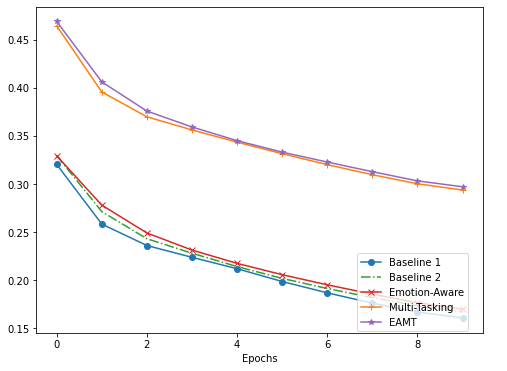

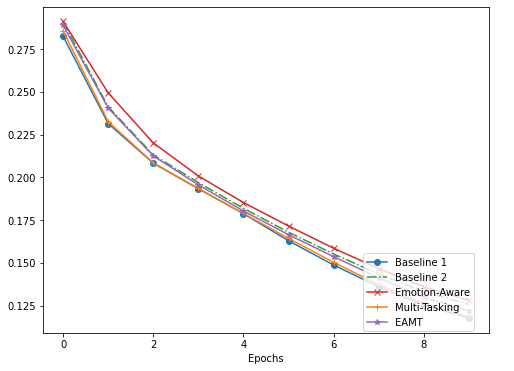

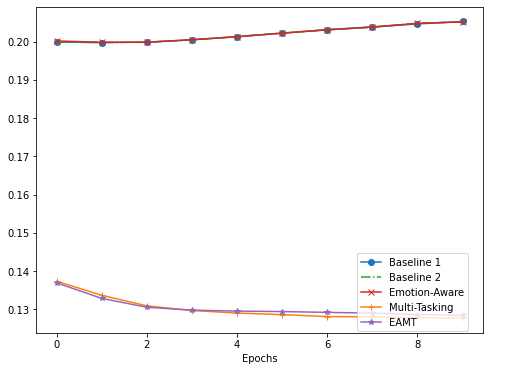

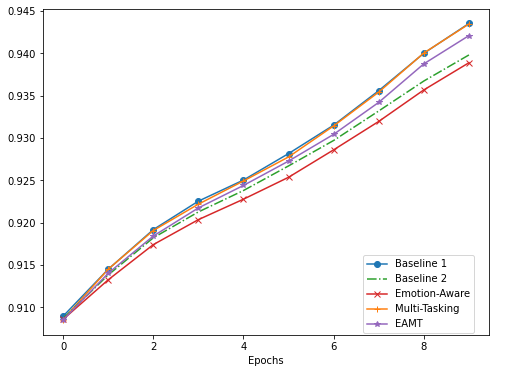

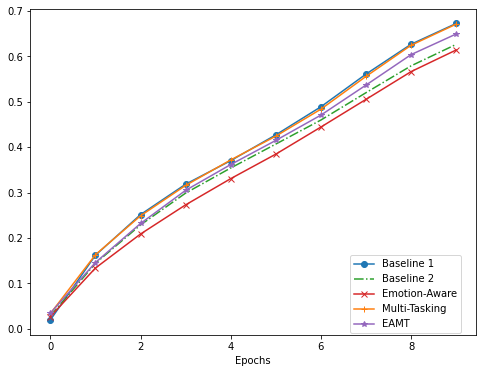

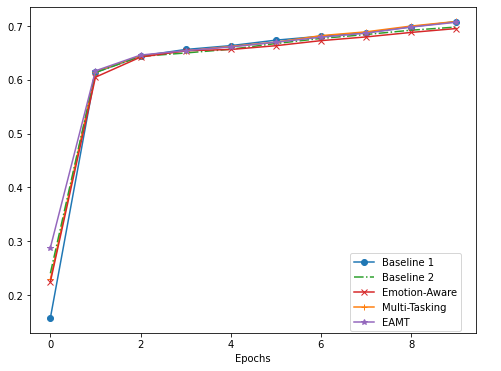

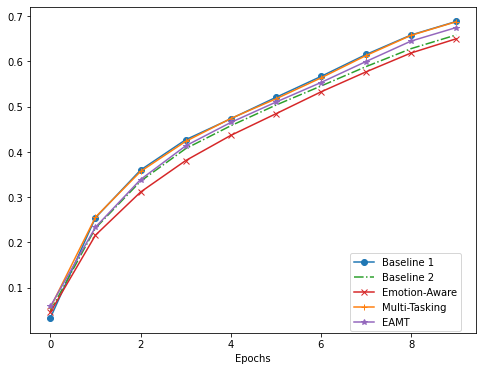

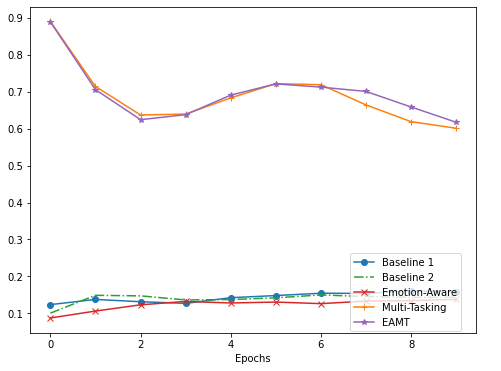

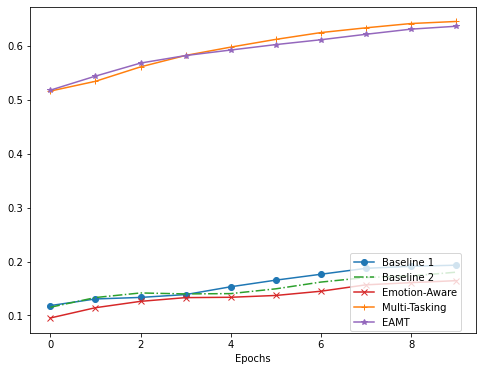

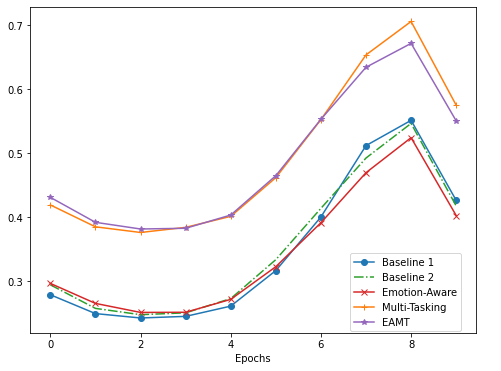

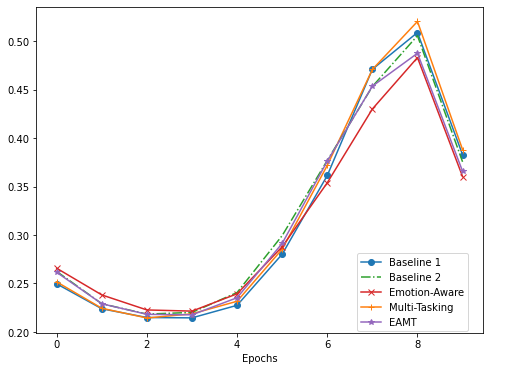

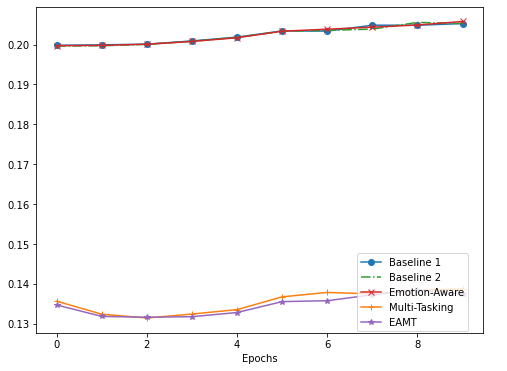

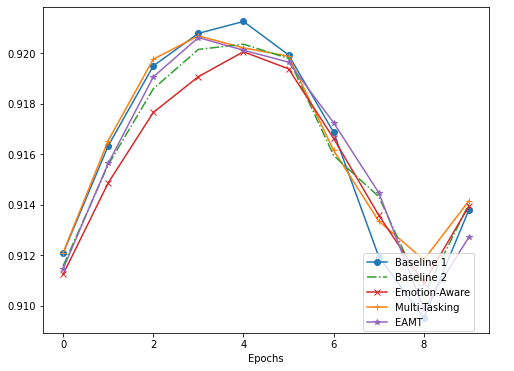

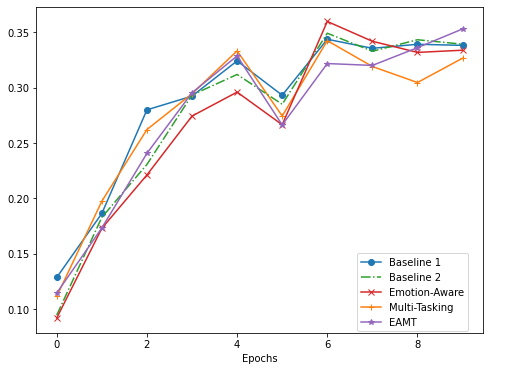

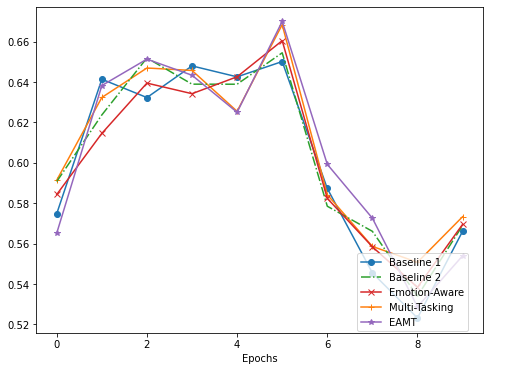

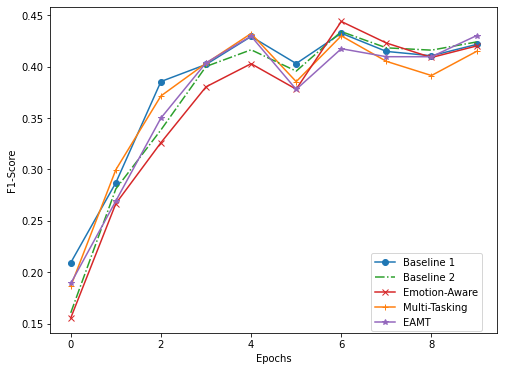

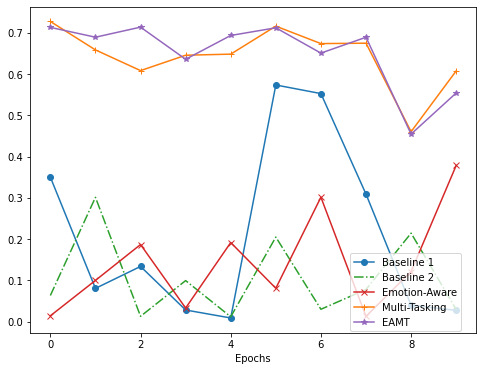

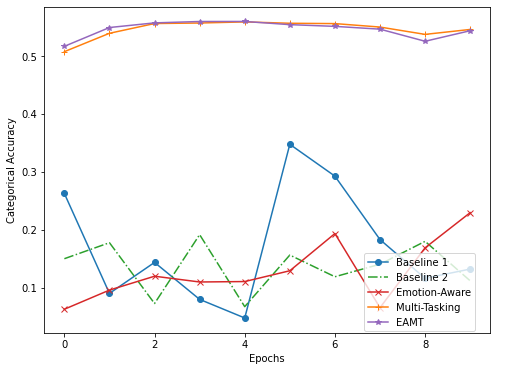

In [ ]:
for metric_name, data in train_metrics_dict.items():
  df = pd.DataFrame(data)
  print(metric_name)

  fig = df.plot(figsize=(8, 6), title=metric_titles.get(metric_name, ""), style=["-o", "-+", "-.", "-x", "-*", "-X", "--x"], legend=False)
  fig.set_xlabel("Epochs")
  fig.set_ylabel(metric_axes.get(metric_name, ""))
  
  fig = fig.get_figure()
  fig.legend(*(
    [ x[i] for i in [0, 2, 3, 1, 4] ]
    for x in fig.gca().get_legend_handles_labels()
  ),loc='lower right', ncol=1, borderaxespad=4)


In [ ]:
# !rm histories.pkl

In [ ]:
# exp.calculate_rank_metrics(model, test_batches_gen, grouped_test)

In [ ]:
# scores, emotions = model.predict(test_batches_gen())

In [ ]:
# dataset.indexed_comment_emotions_binned

In [ ]:
# emotions[0]

In [ ]:
# s = sum(dataset.class_weights.values())

In [ ]:
# pc = { k: s/v for k, v in dataset.class_weights.items() }

In [ ]:
# pcs = sum(pc.values())

In [ ]:
# pcf = { k: v/pcs for k, v in pc.items() }

In [ ]:
# pcf

In [ ]:
# emotion_vectors = np.asarray(list(dataset.indexed_comment_emotions.values()))

In [ ]:
# expected_emotion = np.mean(emotion_vectors, axis=0)

In [ ]:
# expected_emotion

In [ ]:
# np.mean( dataset.indexed_comment_emotions

In [ ]:
# MRR = []
# CG = []
# NDCG = []
# HDCG = []
# UHDCG = []
# HDCG2 = []
# UHDCG2 = []

# def combine_scores(com, em):
#   return com * em

# target_index = 1

# # expected_rel = expected_emotion[target_index]

# for (user, items), s, hs in tqdm(zip(grouped_test, chunks(scores, 1000), chunks(emotions, 1000)), total=len(grouped_test)):
#   # if len(items) > 3:
#   sc = np.asarray([s_i[0] for s_i in s])
#   hsc = np.asarray([hs_i[target_index] for hs_i in list(hs)])
#   # print(sc)
#   # print(hsc)
#   # print(sc[0:len(items)])
#   # print(hsc)

#   ranks = st.rankdata(-sc)
#   # print(ranks)
  
#   positive_ranks = ranks[list(range(len(items)))]

#   # print(len(items))
#   # print(list(range(len(items))))
#   # print(positive_ranks)
#   # # print(ranks)

#   mrr = (1.0 / positive_ranks).mean()
#   MRR.append(mrr)
  
#   true_relevance = [1] * len(items) + [0] * (len(sc) - len(items))
#   # print(true_relevance)

#   happy = [dataset.indexed_comment_emotions_binned[(user, item)][target_index] for item in items]
#   happy2 = [2 ** (5 * h)  for h in happy]
  
#   # print(happy)
      
#   # print(sum(happy))
  
#   # print(happy2)
  
#   # print(sum(happy2))

#   # # break
#   happy_relevance = happy  + [0] * (len(sc) - len(items))

#   happy_relevance2 = happy2  + [0] * (len(sc) - len(items))
  
#   # # print(happy_relevance)
#   # # sc = [sc_ if ranks[i] < 10 else 0  for i, sc_ in enumerate(sc)]
#   # hsc = [hsc_ if hsc_ > expected_rel else expected_rel  for i, hsc_ in enumerate(hsc) ]

#   # # sc = [sc_ if sc_ > 0.1 else 0  for i, sc_ in enumerate(sc)]
  
#   ndcg = ndcg_score([true_relevance], [sc])
#   NDCG.append(ndcg)

#   reranked = [combine_scores(l, m) for i, (l, m) in enumerate(zip(sc, hsc))]
#   # print(reranked)

#   # print(reranked[0:len(items)])
#   # # print(reranked)

#   happy_ndcg = ndcg_score([happy_relevance], [reranked], k=10)
#   HDCG.append(happy_ndcg)

#   happy_ndcg2 = ndcg_score([happy_relevance2], [reranked], k=10)
#   HDCG2.append(happy_ndcg2)

#   unhappy_ndcg = ndcg_score([happy_relevance], [sc], k=10)
#   UHDCG.append(unhappy_ndcg)

#   unhappy_ndcg2 = ndcg_score([happy_relevance2], [sc], k=10)
#   UHDCG2.append(unhappy_ndcg2)

#   # print(happy_ndcg)

#   # print(unhappy_ndcg)

# mrr = np.round(np.mean(MRR), 5)
# print("mrr:", mrr)

# ndcg = np.round(np.mean(NDCG), 5)
# print("ndcg:", ndcg)

# happy_ndcg = np.round(np.mean(HDCG), 5)
# print("happy_ndcg:", happy_ndcg)

# happy_ndcg2 = np.round(np.mean(HDCG2), 5)
# print("happy_ndcg2:", happy_ndcg2)


# unhappy_ndcg = np.round(np.mean(UHDCG), 5)
# print("unhappy_ndcg:", unhappy_ndcg)

# unhappy_ndcg2 = np.round(np.mean(UHDCG2), 5)
# print("unhappy_ndcg2:", unhappy_ndcg2)

In [ ]:
exp.models.keys()

dict_keys([])

In [ ]:
model, test_batches_gen, grouped_test = exp.models["model_ca38ee2ce3105ee9c3f5d7f5423ba711"]

In [ ]:
user_embedding_table = model.get_layer("user_embedding_table")

In [ ]:
item_embedding_table = model.get_layer("item_embedding_table")

In [ ]:
user_embeddings = user_embedding_table.get_weights()[0]

In [ ]:
item_embeddings = item_embedding_table.get_weights()[0]

In [ ]:
scores = user_embeddings.dot(item_embeddings.T)

In [ ]:
# df = exp.get_histories_df()

In [ ]:
# df.sort_values(by="val_emotion_weighted_sparse_categorical_accuracy", ascending=False).head(10)

In [ ]:
df.sort_values(by="val_candidate_score_f1_m", ascending=False).head(10)

In [ ]:
!cp histories.pkl /root/reddit/history30April2021

In [ ]:
!mkdir /root/reddit/history30April2021/

In [ ]:
# !cp /root/reddit/history29April2021/histories.pkl histories.pkl

In [ ]:
for model_name, values in exp.histories.items():
  if not values['params']['negative_samples'] == 10:
    print(model_name)

val_candidate_score_f1_m


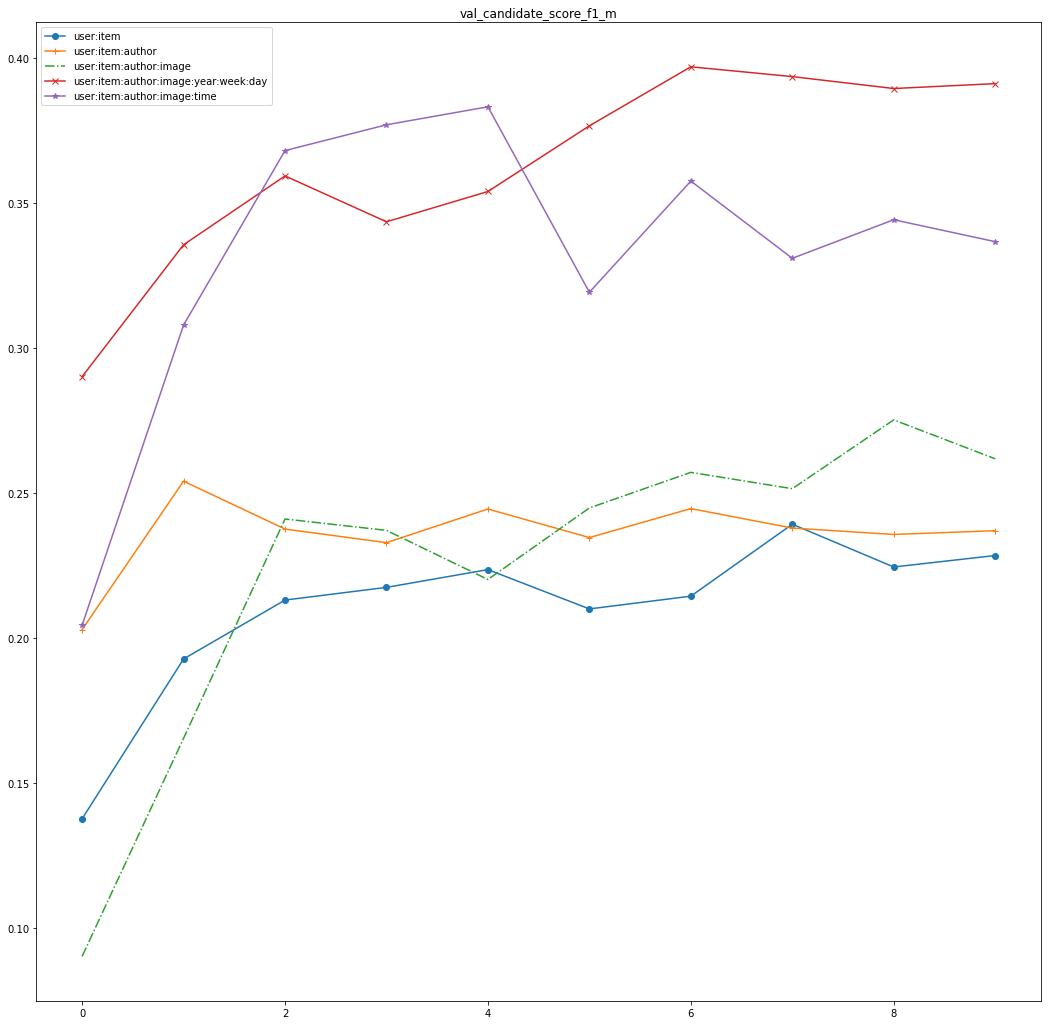

In [ ]:
import pandas as pd 
import time

def f(p, r):
  if p and r:
    return 2 * p * r / (p + r)
  else:
    return 0

excluded = [
  
]

def get_model_name(history):
  name = ":".join(history["params"]["feature_set"])
  
  if history["params"]["loss_weights"][1]:
    name += ":multitask"

  
  return name

for metric in ["val_candidate_score_f1_m"]:
  data = { ":".join(history["params"]["feature_set"]): history['history'][metric] for model_name, history in exp.histories.items() if model_name not in excluded and metric in history['history']}
  df = pd.DataFrame(data)
  print(metric)
  fig = df.plot(figsize=(18, 18), title=metric, style=["-o", "-+", "-.", "-x", "-*", "-X", "--x"]).get_figure()
  # fig.savefig(f'{ROOT_DIR}/{metric}_{time.time()}.png') 